In [29]:
# Notebook: Model Training - MCPA 911
# Author: Thomas Purk
# Date: 2025-03-25
# Reference: 

# Model Training

In [30]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/emergency-911-calls-mcpa/911-processed.csv
/kaggle/input/emergency-911-calls-mcpa/911.csv
/kaggle/input/emergency-911-calls-mcpa/911-encoded.csv


In [31]:
# Validate package and version
!pip list | grep sklearn

sklearn-pandas                     2.2.0


In [32]:
# Notebook Step up steps

# SciKit Learn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, classification_report, confusion_matrix, r2_score

# For saving models
import pickle

# Prevent Pandas and other warnings from displaying above outputcells, improve readability
import warnings
warnings.filterwarnings('ignore')

# Load visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Load the data 
df_in_path = '/kaggle/input/emergency-911-calls-mcpa/911-processed.csv'
df_911 = pd.read_csv(df_in_path)
df_911.info() # validate

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649696 entries, 0 to 649695
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   twp           649696 non-null  object
 1   e             649696 non-null  int64 
 2   service_type  649696 non-null  object
 3   service_desc  649696 non-null  object
 4   month         649696 non-null  int64 
 5   day_of_week   649696 non-null  int64 
 6   day_night     649696 non-null  object
dtypes: int64(3), object(4)
memory usage: 34.7+ MB


In [33]:
# Prepare the data

#Group the data to count the number of events per category.
cols = ['twp', 'month', 'day_of_week','day_night', 'service_type', 'service_desc']
# Columns of interest - Which type of vehicles (service type) does a township need the most?
df_911_sub = df_911[cols]
# Grouping
group_911 = df_911_sub.groupby(cols)
# New DataFrame
df_911_grouped = group_911.size().reset_index(name='call_count')

# Encode data and labels
df_for_encoding = df_911_grouped[cols]

# One-hot encode categorical features
encoder = OneHotEncoder(drop='first', sparse=False)
encoded_features = encoder.fit_transform(df_for_encoding)


In [34]:
# Prepare training features and labels

# Convert encoded features to a DataFrame
X = pd.DataFrame(
    data=encoded_features, 
    columns=encoder.get_feature_names_out()
)
# Convert labels to numerical formate
y = df_911_grouped['call_count']

# Split the data training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42
)


In [ ]:
# Train the Model
# Long run - only re-run if updating the model is necessary

# Train Random Forest Regressor
rfr_model = RandomForestRegressor(
    n_estimators=100, 
    random_state=42,
    verbose=1
)
rfr_model.fit(X_train, y_train)

print("Random Forest Model Trained Successfully!")



In [35]:
# Load the model - Start here unless model needs to be recreated
with open('rfr_model.pkl', 'rb') as f:
    rfr_model = pickle.load(f)

rfr_model

RandomForestRegressor(random_state=42, verbose=1)

In [ ]:
# Save the model
with open('rfr_model.pkl', 'wb') as f:
    pickle.dump(rfr_model, f)

In [37]:
# Make predictions on test data
y_pred = rfr_model.predict(X_test)

# Evaluate model performance using MAE and RMSE
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Evaluate the RMSE and MAE relative to the characteri
# Test Data characteristics
data_range = y_test.max() - y_test.min()
std_dev = np.std(y_test)

# Print comparison
print('--------- Baseline Model Metrics -------------')
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f'Coeff of Determination (R^2): {r2:.2f}')
print('')
print('--------- Data Characterization --------------')
print(f"Test Data Range: {data_range}")
print(f"Test Data Standard Deviation: {std_dev:.2f}")
print('')
print('--------- Comparison & Insights --------------')
print(f"RMSE as % of Range: {rmse / data_range * 100:.2f}%")
print(f"MAE as % of Range: {mae / data_range * 100:.2f}%")
print(f"RMSE as % of Std Dev: {rmse / std_dev * 100:.2f}%")
print(f"MAE as % of Std Dev: {mae / std_dev * 100:.2f}%")

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.9s


--------- Baseline Model Metrics -------------
Mean Absolute Error (MAE): 1.52
Root Mean Squared Error (RMSE): 2.94
Coeff of Determination (R^2): 0.85

--------- Data Characterization --------------
Test Data Range: 232
Test Data Standard Deviation: 7.58

--------- Comparison & Insights --------------
RMSE as % of Range: 1.27%
MAE as % of Range: 0.65%
RMSE as % of Std Dev: 38.87%
MAE as % of Std Dev: 20.05%


# Model Optimization

In [ ]:
# NOTE: DO NOT RUN in Kaggle
# Unfortunately, this grid search ran very long and did not finish in Kaggle.
# Attempt to replace with random search to optimize hyperparameters.

# Grid Search Optimization
# from sklearn.model_selection import GridSearchCV


# rfr_model_grid = RandomForestRegressor(
#     random_state=42,
#     verbose=1
# )

# rfr_param_grid = {
#     'n_estimators': [100, 200, 300], # The number of trees in the forest.
#     'max_depth': [10, 20, None], #  The maximum depth of the tree. Prevents overfitting.
#     'min_samples_split': [2, 5, 10], # The minimum number of samples required to split an internal node
#     'min_samples_leaf': [1, 2, 4], #  The minimum number of samples required to be at a leaf node.
#     'max_features': ['auto', 'sqrt', 'log2'] #  The number of features to consider when looking for the best split
# }


# grid_search = GridSearchCV(
#     estimator=rfr_model_grid,
#     param_grid=rfr_param_grid,
#     cv=3, # Determines the cross-validation splitting strategy.- integer, to specify the number of folds in a `(Stratified)KFold`,
#     scoring='neg_mean_absolute_error', 
#     n_jobs=-1
# )
# grid_search.fit(X_train, y_train)

# print(f"Best Parameters: {grid_search.best_params_}")

In [ ]:
# NOTE: DO NOT RUN in Kaggle
# Unfortunately the random search also ran for a long time and did not finish in Kaggle

# # Alternative to Grid Search Optimization
# ''' From RandomizedSearchCV DocString
#  |  In contrast to GridSearchCV, not all parameter values are tried out, but
#  |  rather a fixed number of parameter settings is sampled from the specified
#  |  distributions. The number of parameter settings that are tried is
#  |  given by n_iter.
# '''
# from sklearn.model_selection import RandomizedSearchCV

# rfr_model_dist = RandomForestRegressor(
#     random_state=42,
#     verbose=1
# )

# rfr_param_dist = {
#     'n_estimators': np.arange(100, 1000, 100),
#     'max_depth': [None, 10, 20, 30, 50],
#     'min_samples_split': np.arange(2, 20, 2),
#     'min_samples_leaf': np.arange(1, 10, 2),
#     'max_features': ['auto', 'sqrt', 'log2']
# }

# # estimator - An object of that type is instantiated for each grid point.
# # param_distributions - Dictionary with parameters names (`str`) as keys and distributions or lists of parameters to try
# # n_iter -  Number of parameter settings that are sampled. n_iter trades off runtime vs quality of the solution.
# # cv - Determines the cross-validation splitting strategy.- integer, to specify the number of folds in a `(Stratified)KFold`,
# # scoring - Strategy to evaluate the performance of the cross-validated model on the test set.
# # n_jobs - Number of jobs to run in parallel `-1` means using all processors

# dist_search = RandomizedSearchCV(
#     estimator=rfr_model_dist,
#     param_distributions=rfr_param_dist,
#     n_iter=10, 
#     cv=5,
#     n_jobs=-1,
#     scoring='r2',
#     random_state=42
# )
# dist_search.fit(X_train, y_train)

In [ ]:
# NOTE: This is a very trimmed down grid optimization example to see if it would run in Kaggle.
# In a more robust compute environment a more real-world approach should be taken

# Grid Search Optimization
from sklearn.model_selection import GridSearchCV


rfr_model_grid = RandomForestRegressor(
    random_state=42,
    verbose=2
)

rfr_param_grid = {
    'n_estimators': [100], # The number of trees in the forest.
    'max_depth': [None, 10], #  The maximum depth of the tree. Prevents overfitting.
    'min_samples_split': [10], # The minimum number of samples required to split an internal node
    'min_samples_leaf': [4], #  The minimum number of samples required to be at a leaf node.
    'max_features': ['auto'] #  The number of features to consider when looking for the best split
}


grid_search = GridSearchCV(
    estimator=rfr_model_grid,
    param_grid=rfr_param_grid,
    cv=3, # Determines the cross-validation splitting strategy.- integer, to specify the number of folds in a `(Stratified)KFold`,
    scoring='neg_mean_absolute_error', 
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

print(f"Best Parameters: {grid_search.best_params_}")

# Evaluation

In [38]:
best_rf = grid_search.best_estimator_  # Use the best model found
best_rf

RandomForestRegressor(max_features='auto', min_samples_leaf=4,
                      min_samples_split=10, random_state=42, verbose=2)

In [39]:
# Evaluate on the Test set

y_pred_final = best_rf.predict(X_test)

# Evaluate model performance using MAE and RMSE
final_mae = mean_absolute_error(y_test, y_pred_final)
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred_final))
final_r2 = r2_score(y_test, y_pred)

# Evaluate the RMSE and MAE relative to the characteri
# Test Data characteristics
data_range = y_test.max() - y_test.min()
std_dev = np.std(y_test)

# Print comparison
print('--------- Baseline Model Metrics -------------')
print(f"Final Mean Absolute Error (MAE): {final_mae:.2f}")
print(f"Final Root Mean Squared Error (RMSE): {final_rmse:.2f}")
print(f'Final Coeff of Determination (R^2): {final_r2:.2f}')
print('')
print('--------- Data Characterization --------------')
print(f"Test Data Range: {data_range}")
print(f"Test Data Standard Deviation: {std_dev:.2f}")
print('')
print('--------- Comparison & Insights --------------')
print(f"RMSE as % of Range: {final_rmse / data_range * 100:.2f}%")
print(f"MAE as % of Range: {final_mae / data_range * 100:.2f}%")
print(f"RMSE as % of Std Dev: {final_rmse / std_dev * 100:.2f}%")
print(f"MAE as % of Std Dev: {final_mae / std_dev * 100:.2f}%")

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.5s


--------- Baseline Model Metrics -------------
Final Mean Absolute Error (MAE): 1.20
Final Root Mean Squared Error (RMSE): 2.32
Final Coeff of Determination (R^2): 0.85

--------- Data Characterization --------------
Test Data Range: 232
Test Data Standard Deviation: 7.58

--------- Comparison & Insights --------------
RMSE as % of Range: 1.00%
MAE as % of Range: 0.52%
RMSE as % of Std Dev: 30.58%
MAE as % of Std Dev: 15.88%


In [ ]:
# The above numbers are an improvement over the initial set

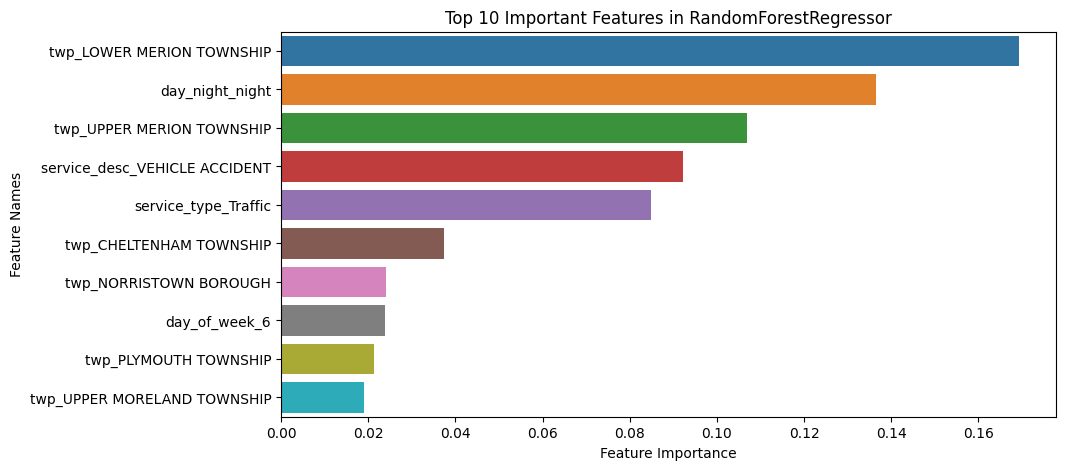

In [40]:
# Feature importance analysis
import matplotlib.pyplot as plt
import seaborn as sns

feature_importance = best_rf.feature_importances_
sorted_idx = np.argsort(feature_importance)[::-1]

plt.figure(figsize=(10, 5))
sns.barplot(x=feature_importance[sorted_idx][:10], y=X.columns[sorted_idx][:10])
plt.xlabel("Feature Importance")
plt.ylabel("Feature Names")
plt.title("Top 10 Important Features in RandomForestRegressor")
plt.show()